In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import PIL
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score
import seaborn as sns
import time
from tqdm import tqdm_notebook
import os
print(os.listdir("/content/drive/MyDrive/Dataset/aptos2019"))
base_dir = "/content/drive/MyDrive/Dataset/aptos2019/"

['train.csv', 'sample_submission.csv', 'test.csv', 'test_images', 'train_images']


In [2]:
train_csv = pd.read_csv('/content/drive/MyDrive/Dataset/aptos2019/train.csv')
test_csv = pd.read_csv('/content/drive/MyDrive/Dataset/aptos2019/test.csv')

In [3]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 3662
Public Test Size = 1928


In [4]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


<ipython-input-5-461e6f912b62>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index,y=counts.values, alpha=0.8, palette='bright')


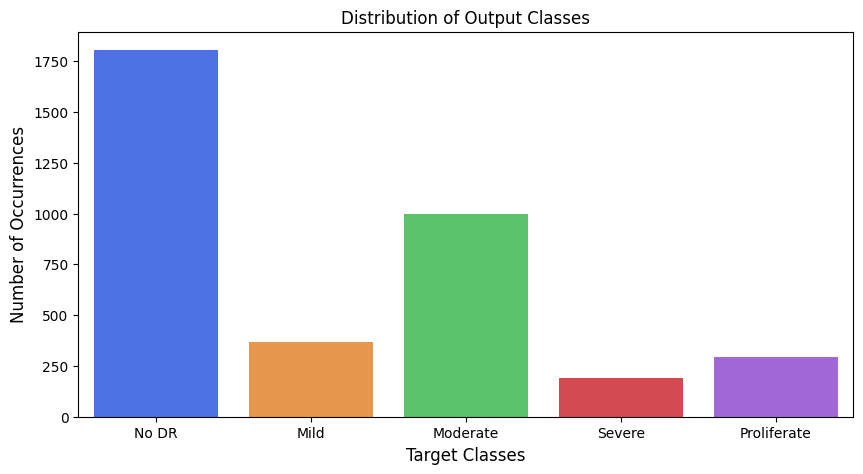

In [5]:
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10,5))
sns.barplot(x=counts.index,y=counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

**Visualizing Training Set**

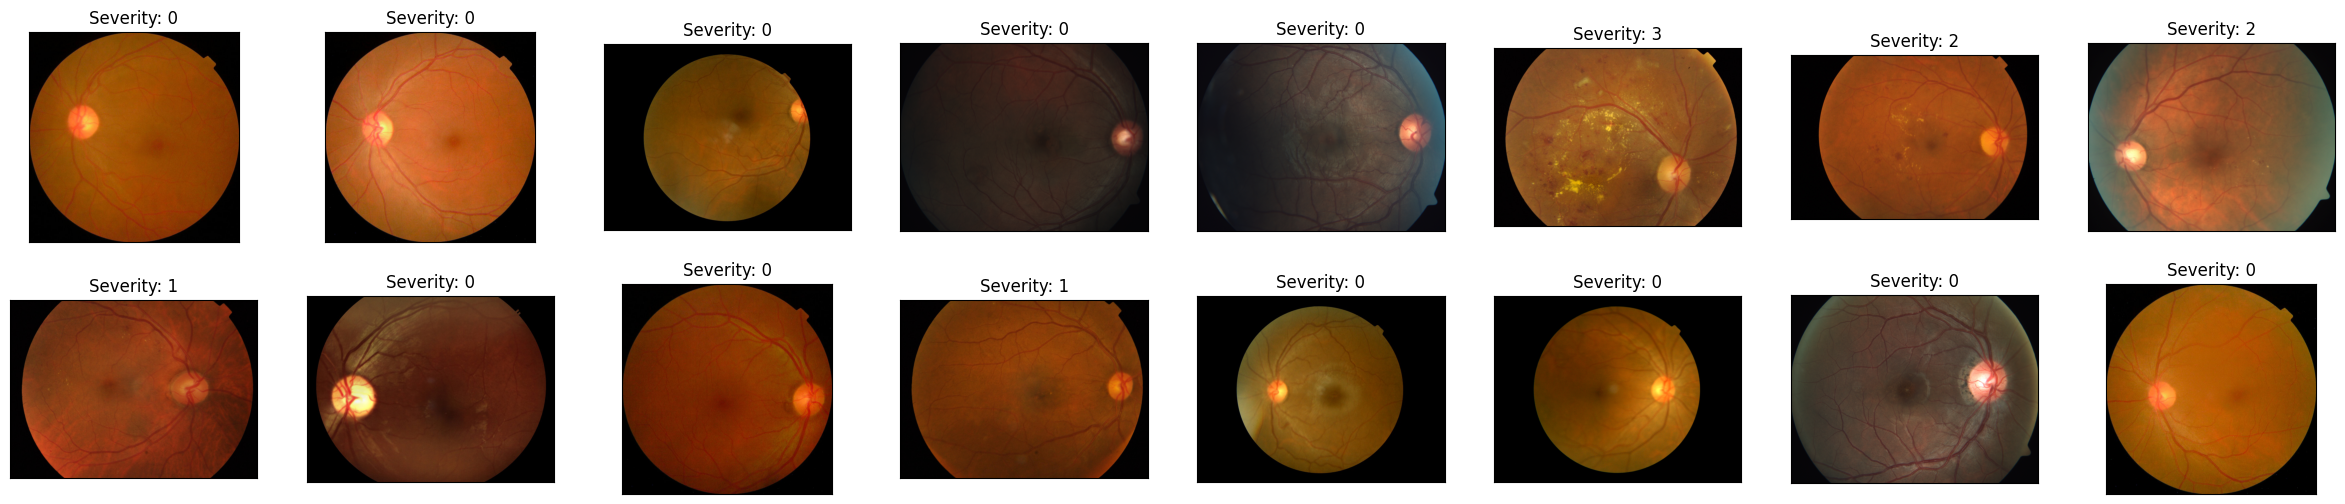

In [6]:
fig = plt.figure(figsize=(30, 6))
train_imgs = os.listdir(base_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

**Visualizing Test Set**

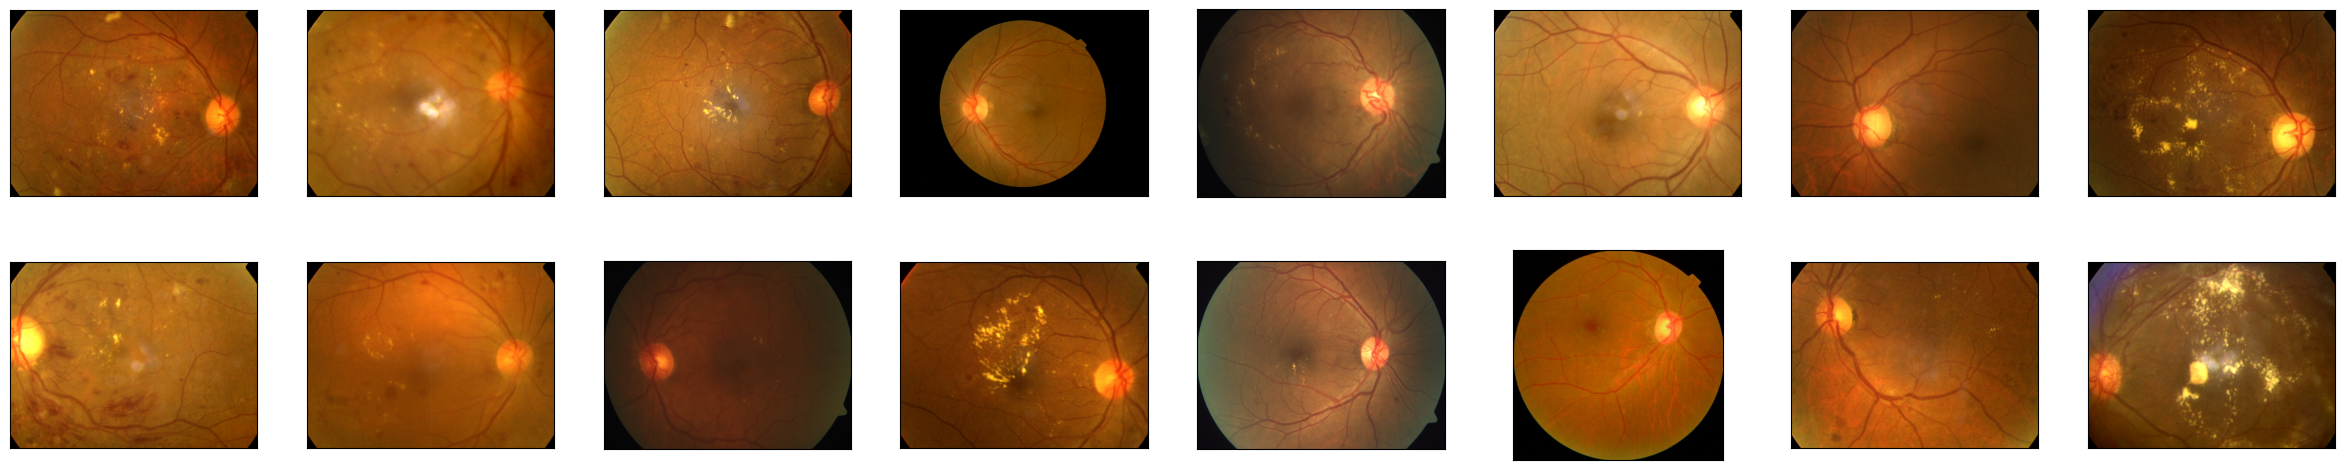

In [7]:
fig = plt.figure(figsize=(30, 6))
test_imgs = os.listdir(base_dir+"/test_images")
for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/test_images/" + img)
    plt.imshow(im)

**Data Processing**

In [8]:
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '/content/drive/MyDrive/Dataset/aptos2019/train_images', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [9]:
train_transforms = transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(p=0.4),
    torchvision.transforms.ColorJitter(brightness=2, contrast=2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [10]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [11]:
train_path = "/content/drive/MyDrive/Dataset/aptos2019/train_images/"
test_path = "/content/drive/MyDrive/Dataset/aptos2019/test_images/"

In [12]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

In [13]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [14]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [15]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [16]:
print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 3662
testing examples contain : 1928
46
12
31


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
out_ftrs = 5
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 112MB/s]


In [18]:
model_save_name = 'classifier.pt'

In [19]:
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [20]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [21]:
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [22]:
model = load_model("/content/drive/MyDrive/archive/classifier.pt")

In [23]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
58970117


In [25]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses, acc = [] , [], []
    valid_loss_min = np.Inf
    model.train()
    print('Model Training started.....')
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      for image , label in trainloader:
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        if batch % 10 == 0:
            print(f" epoch {epoch + 1} batch {batch} completed")
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        print(f"validation started for {epoch + 1}")
        model.eval()
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images)
          test_loss += criterion(logps,labels)
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      acc.append(accuracy)
      scheduler.step()
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train()
      if test_loss/len(validloader) <= valid_loss_min:
        print("Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(valid_loss_min,test_loss/len(validloader)))
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = test_loss/len(validloader)
    print("Training Completed Succesfully !")
    return train_losses, test_losses, acc
train_losses, valid_losses, acc = train_and_test(0)

Model Training started.....
Training Completed Succesfully !


Model Training started.....

 epoch 1 batch 10 completed

 epoch 1 batch 20 completed

 epoch 1 batch 30 completed

 epoch 1 batch 40 completed

validation started for 1

Epoch: 1/5..  Training Loss: 0.138..  Valid Loss: 0.115..  Valid Accuracy: 0.958

 epoch 2 batch 10 completed

 epoch 2 batch 20 completed

 epoch 2 batch 30 completed

 epoch 2 batch 40 completed

validation started for 2

Epoch: 2/5..  Training Loss: 0.092..  Valid Loss: 0.122..  Valid Accuracy: 0.960

 epoch 3 batch 10 completed

 epoch 3 batch 20 completed

 epoch 3 batch 30 completed

 epoch 3 batch 40 completed

validation started for 3

Epoch: 3/5..  Training Loss: 0.081..  Valid Loss: 0.113..  Valid Accuracy: 0.964

 epoch 4 batch 10 completed

 epoch 4 batch 20 completed

 epoch 4 batch 30 completed

 epoch 4 batch 40 completed

validation started for 4

Epoch: 4/5..  Training Loss: 0.079..  Valid Loss: 0.120..  Valid Accuracy: 0.962

 epoch 5 batch 10 completed

 epoch 5 batch 20 completed

 epoch 5 batch 30 completed

 epoch 5 batch 40 completed

validation started for 5

Epoch: 5/5..  Training Loss: 0.073..  Valid Loss: 0.107..  Valid Accuracy: 0.967

Validation loss decreased (0.113338 --> 0.106542).  Saving model ...

Training Completed Succesfully !

In [26]:
def round_off_preds(preds, coef=[0.5, 1.5, 2.5, 3.5]):
    for i, pred in enumerate(preds):
            if pred < coef[0]:
                preds[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                preds[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                preds[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                preds[i] = 3
            else:
                preds[i] = 4
    return preds

In [27]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [28]:
def predict(testloader):
    '''Function used to make predictions on the test set'''
    model.eval()
    preds = []
    for batch_i, (data, target) in enumerate(testloader):
        data, target = data.cuda(), target.cuda()
        output = model(data)
        pr = output.detach().cpu().numpy()
        for i in pr:
            preds.append(i.item())

    return preds

In [29]:
def test_with_single_image(model, file, transform, classes):

    file = Image.open(file).convert('RGB')

    img = transform(file).unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        out = model(img.to(device))
        ps = torch.exp(out)
        top_p, top_class = ps.topk(1, dim=1)
        value = top_class.item()
        print("Value:", value)
        print(classes[value])
        plt.imshow(np.array(file))
        plt.show()

In [30]:
import random
test_dir = "/content/drive/MyDrive/Dataset/aptos2019"
folders = os.listdir(test_dir)
num = 4
path = test_dir+"/"+folders[num]
print(path)
label = folders[num]
files = os.listdir(path)
num = random.randint(0, len(files)-1)
name = path + "/" + files[num]
print('Path: ', name)

/content/drive/MyDrive/Dataset/aptos2019/train_images
Path:  /content/drive/MyDrive/Dataset/aptos2019/train_images/5dc23e440de3.png


In [31]:
#name="/content/ui.jpg"

Value: 2
Moderate


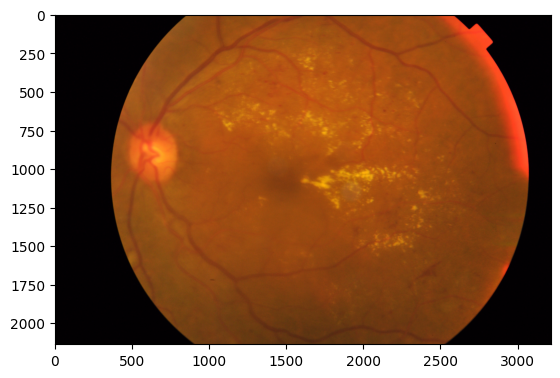

In [32]:
classes = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
test_with_single_image(model, name, test_transforms, classes)